In [538]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [471]:
df = pd.read_csv('AMZN.csv')
df = df[['Date', 'Open']]
df.Date = pd.to_datetime(df.Date)
df_open = deepcopy(df)

df = pd.read_csv('AMZN.csv')
df = df[['Date', 'Close']]
df.Date = pd.to_datetime(df.Date)
df_close = deepcopy(df)

df = pd.read_csv('AMZN.csv')
df = df[['Date', 'High']]
df.Date = pd.to_datetime(df.Date)
df_high = deepcopy(df)

df = pd.read_csv('AMZN.csv')
df = df[['Date', 'Low']]
df.Date = pd.to_datetime(df.Date)
df_low = deepcopy(df)

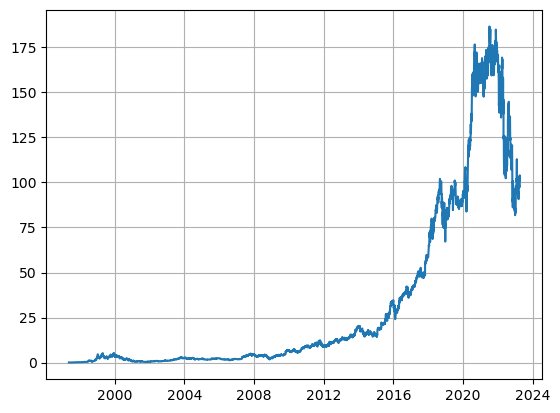

In [472]:
plt.plot(df_close.Date, df_close.Close)
plt.grid()
plt.show()

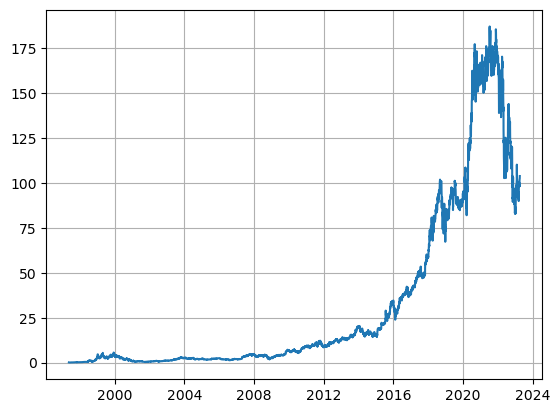

In [473]:
plt.plot(df_open.Date, df_open.Open)
plt.grid()
plt.show()

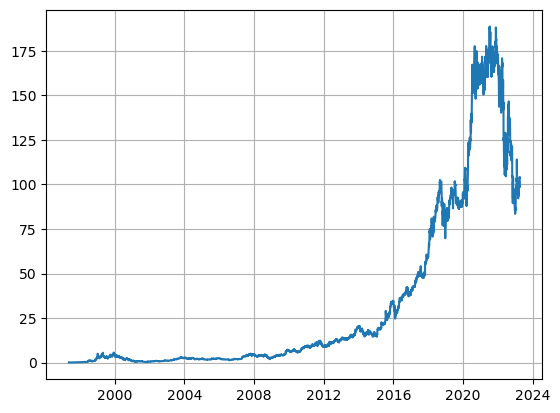

In [474]:
plt.plot(df_high.Date, df_high.High)
plt.grid()
plt.show()

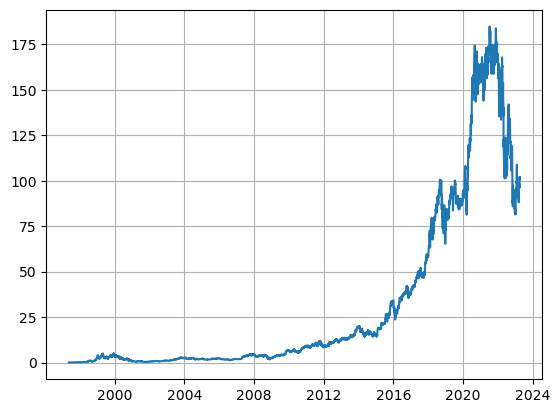

In [475]:
plt.plot(df_low.Date, df_low.Low)
plt.grid()
plt.show()

In [476]:
# Preparação dos Dados para LSTM
# Cada instância:
# x_i .... x_t | x_{t+1}
def do_windowing(df, column, window_size):
    df_copy = deepcopy(df)
    df_copy.set_index('Date', inplace = True)
    for t in range(1, window_size + 1)[::-1]:
        df_copy[f'{column}(t-{t})'] = df_copy[column].shift(t)
    df_copy.dropna(inplace=True)
    return df_copy

In [477]:
df_close = do_windowing(df_close, 'Close', window_size = 20)

In [478]:
df_open = do_windowing(df_open, 'Open',window_size = 20)

In [479]:
df_high = do_windowing(df_high, 'High', window_size = 20)

In [480]:
df_low = do_windowing(df_low, 'Low', window_size = 20)

In [481]:
data_close = df_close.values
scaler = MinMaxScaler()
data_close = scaler.fit_transform(data_close)

data_open = df_open.values
scaler = MinMaxScaler()
data_open = scaler.fit_transform(data_open)

data_high = df_high.values
scaler = MinMaxScaler()
data_high = scaler.fit_transform(data_high)

data_low = df_low.values
scaler = MinMaxScaler()
data_low = scaler.fit_transform(data_low)

In [482]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'
print(device)

cpu


In [483]:
y_open, X_open = data_open[:, 0], data_open[:, 1:]
y_close, X_close = data_close[:, 0], data_close[:, 1:]
y_high, X_high = data_high[:, 0], data_high[:, 1:]
y_low, X_low = data_low[:, 0], data_low[:, 1:]

print(y_open.shape, X_open.shape )
print(y_close.shape, X_close.shape )

(6496,) (6496, 20)
(6496,) (6496, 20)


In [484]:
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(
    X_open, y_open, test_size=0.10, random_state=42, shuffle=False)

X_train_close, X_test_close, y_train_close, y_test_close = train_test_split(
    X_close, y_close, test_size=0.10, random_state=42, shuffle=False)

X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(
    X_low, y_low, test_size=0.10, random_state=42, shuffle=False)

X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.10, random_state=42, shuffle=False)

In [485]:
X_train = np.stack((X_train_open, X_train_close, X_train_low, X_train_high), axis=1)
X_train.shape

(5846, 4, 20)

In [486]:
X_test = np.stack((X_test_open, X_test_close, X_test_low, X_test_high), axis=1)
X_test.shape

(650, 4, 20)

In [487]:
y_train = np.stack((y_train_open, y_train_close, y_train_low, y_train_high), axis=1)
y_train.shape

(5846, 4)

In [488]:
y_test = np.stack((y_test_open, y_test_close, y_test_low, y_test_high), axis=1)
y_test.shape

(650, 4)

In [489]:
# Inclui uma Dimensão adicional para compatibilidade com o PyTorch
#X_train = X_train.reshape([-1,4, window_size, 1])
#X_test = X_test.reshape([-1, 4,window_size, 1])
#y_train = y_train.reshape([-1,4, 1])
#y_test = y_test.reshape([-1,4, 1])
#
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [490]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5846, 4, 20]),
 torch.Size([650, 4, 20]),
 torch.Size([5846, 4]),
 torch.Size([650, 4]))

In [491]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_ds = StockDataset(X_train, y_train)
test_ds = StockDataset(X_test, y_test)

In [492]:
train_loader = DataLoader(train_ds, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle=False)

In [493]:
x_batch, y_batch = next(iter(train_loader))

print(x_batch.shape, y_batch.shape)

torch.Size([64, 4, 20]) torch.Size([64, 4])


In [494]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = 20, 
            hidden_size = 64, 
            num_layers = 1, 
            batch_first=True # (batch, seq, feature) 
        )
        self.fc = nn.Linear(hidden_size, 4)
        
    def forward(self, x):
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(20, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [495]:
# testa o forward
input_data = torch.randn(16, 4, 20)
print(input_data.shape)
print(model(input_data).shape)

torch.Size([16, 4, 20])
torch.Size([16, 4])


In [496]:
start = time.time()
model = LSTM()
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

avg_loss_batches_train_list = list()
avg_loss_batches_test_list = list()
for epoch in range(num_epochs):
    model.train(True)
    running_loss= 0.0
    for batch_index, (x_batch, y_batch) in enumerate(train_loader):
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_loss_batches = running_loss / len(train_loader)
    avg_loss_batches_train_list.append(avg_loss_batches)
    
    model.train(False)
    running_loss= 0.0
    for batch_index, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
        
    avg_loss_batches = running_loss / len(test_loader)
    avg_loss_batches_test_list.append(avg_loss_batches)
    
    if epoch % 10 == 0:
        print('Epoch', epoch, 'Test Loss', avg_loss_batches_test_list[-1])
    
end = time.time()

print(f'{(end-start)} secs --> {(end-start)/60} mins.')

Epoch 0 Test Loss 0.012733351968398149
Epoch 10 Test Loss 0.0034055335510691457
Epoch 20 Test Loss 0.0025961412095718765
Epoch 30 Test Loss 0.0037285846351137893
Epoch 40 Test Loss 0.003984503019389443
Epoch 50 Test Loss 0.0027725056279450655
Epoch 60 Test Loss 0.0035744982252998107
Epoch 70 Test Loss 0.0020933126109990885
Epoch 80 Test Loss 0.0029491724007212642
Epoch 90 Test Loss 0.003773401229409501
10.442738771438599 secs --> 0.1740456461906433 mins.


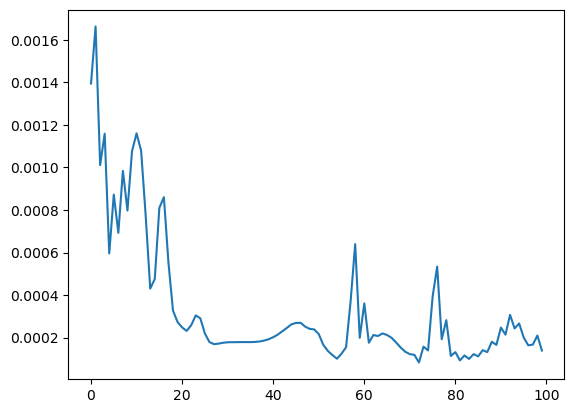

In [497]:
plt.plot(avg_loss_batches_train_list)

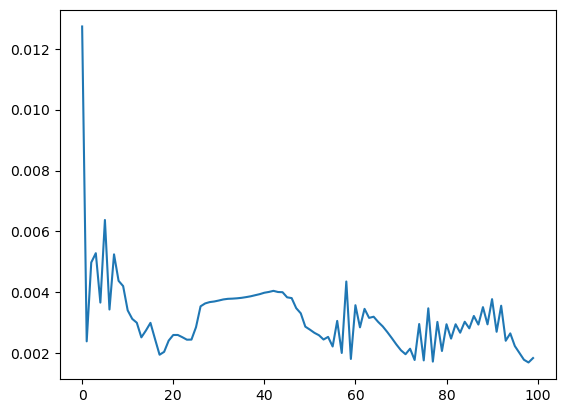

In [498]:
plt.plot(avg_loss_batches_test_list)

In [499]:
with torch.no_grad():
    y_predicted = model(X_train.to(device)).to('cpu').numpy()
y_predicted.shape

(5846, 4)

In [500]:
# ordem: open,, close, low, high
y_train.shape

torch.Size([5846, 4])

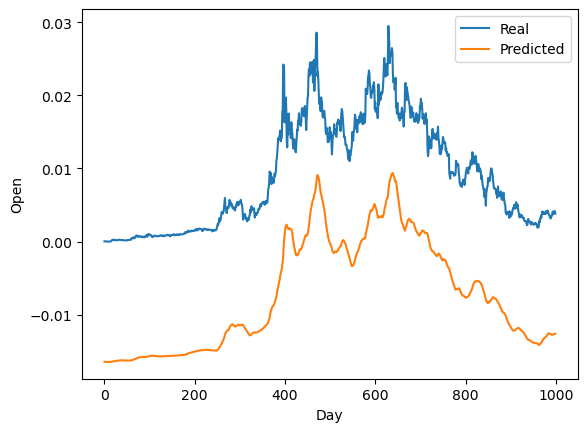

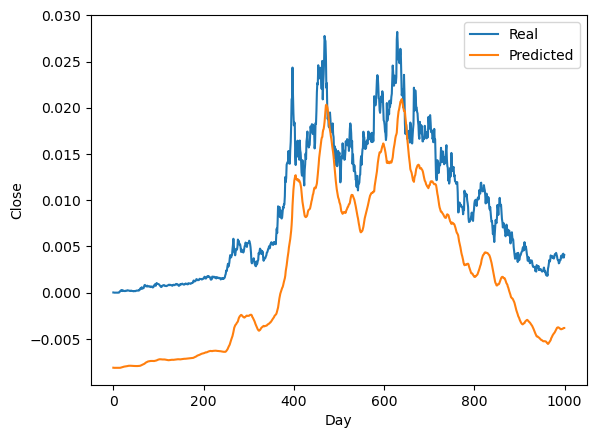

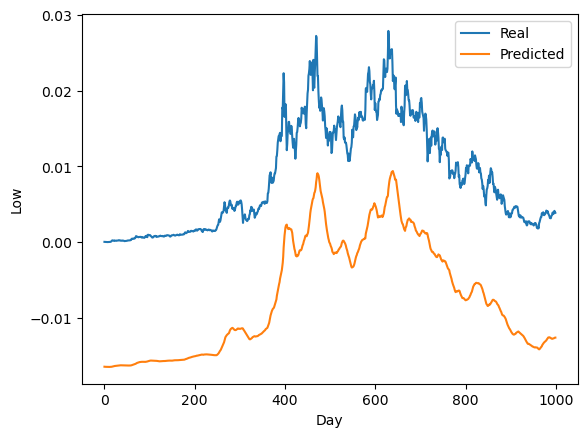

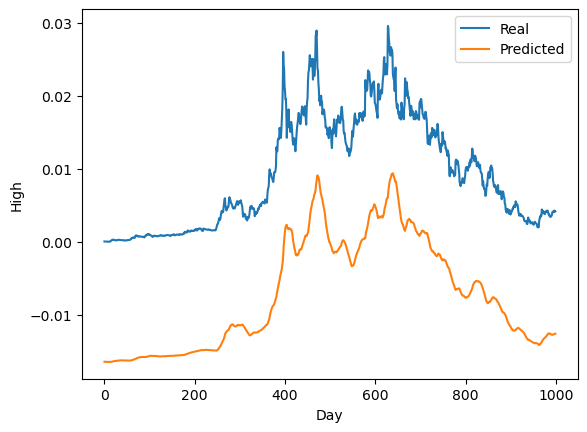

In [501]:
plt.plot(y_train[:1000, 0], label = 'Real')
plt.plot(y_predicted[:1000, 0], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Open')
plt.show()

plt.plot(y_train[:1000, 1], label = 'Real')
plt.plot(y_predicted[:1000, 1], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

plt.plot(y_train[:1000, 2], label = 'Real')
plt.plot(y_predicted[:1000, 0], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Low')
plt.show()

plt.plot(y_train[:1000, 3], label = 'Real')
plt.plot(y_predicted[:1000, 0], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('High')
plt.show()

In [502]:
with torch.no_grad():
    y_predicted = model(X_test.to(device)).to('cpu').numpy()
y_predicted.shape

(650, 4)

In [509]:
y_test.shape, y_predicted.shape

(torch.Size([650, 4]), (650, 4))

In [526]:
mse_loss = nn.MSELoss()
print('MSE (Open)', mse_loss(y_test[:, 0], torch.tensor(y_predicted[:, 0])).item())
print('MSE (Close)', mse_loss(y_test[:, 1], torch.tensor(y_predicted[:, 1])).item())
print('MSE (Low)', mse_loss(y_test[:, 2], torch.tensor(y_predicted[:, 2])).item())
print('MSE (High)', mse_loss(y_test[:, 3], torch.tensor(y_predicted[:, 3])).item())

# Média das MSEs
np.mean([
    mse_loss(y_test[:, 0], torch.tensor(y_predicted[:, 0])),
    mse_loss(y_test[:, 1], torch.tensor(y_predicted[:, 1])),
    mse_loss(y_test[:, 2], torch.tensor(y_predicted[:, 2])),
    mse_loss(y_test[:, 3], torch.tensor(y_predicted[:, 3])),
])


MSE (Open) 0.0017232473473995924
MSE (Close) 0.002299950458109379
MSE (Low) 0.0018654449377208948
MSE (High) 0.0019823864568024874


0.0019677572

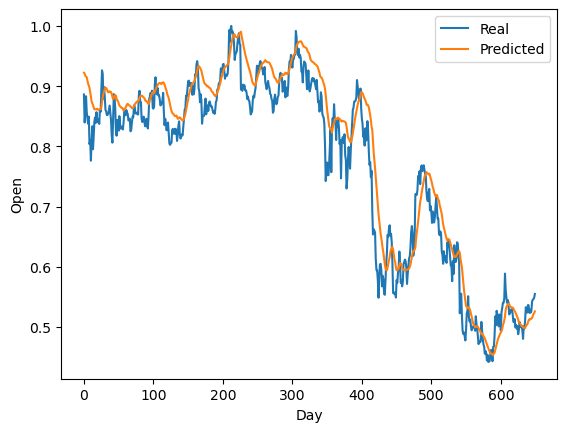

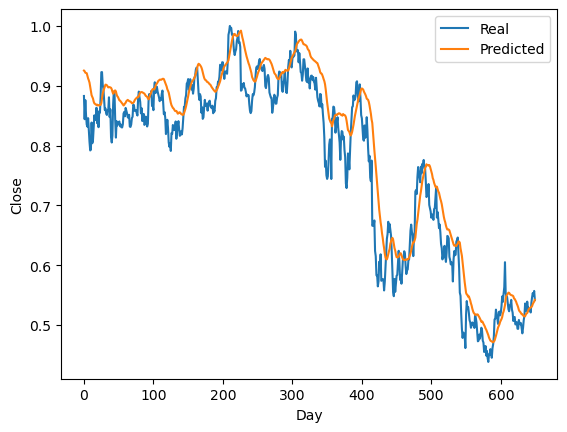

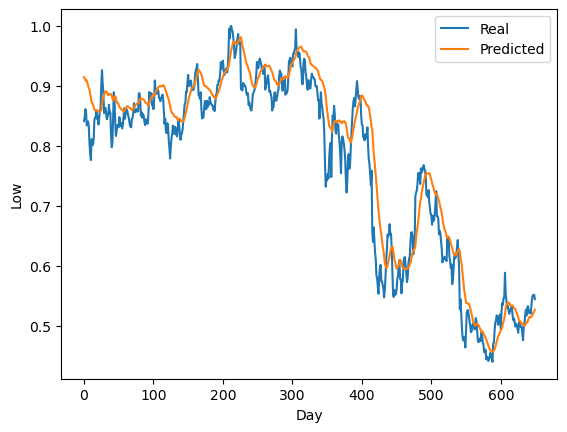

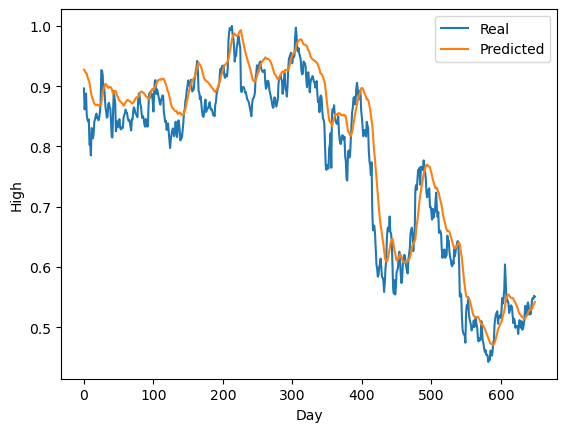

In [527]:
plt.plot(y_test[:1000, 0], label = 'Real')
plt.plot(y_predicted[:1000, 0], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Open')
plt.show()

plt.plot(y_test[:1000, 1], label = 'Real')
plt.plot(y_predicted[:1000, 1], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

plt.plot(y_test[:1000, 2], label = 'Real')
plt.plot(y_predicted[:1000, 2], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Low')
plt.show()

plt.plot(y_test[:1000, 3], label = 'Real')
plt.plot(y_predicted[:1000, 3], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('High')
plt.show()

In [528]:
class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

In [529]:

class CNN1DModel(nn.Module):
    def __init__(self):
        super().__init__()
        # são 4 canais 1D
        self.conv1 = nn.Conv1d(4, 8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        # (N-F+2P)/S+1 = (20-3+2*1)/1 +1 = 20
        # 20 * 8 canais = 160
        self.fc1 = nn.Linear(160, 32) 
        self.fc2 = nn.Linear(32, 4)
 
    def forward(self, x):
        x = self.relu(self.conv1(x))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)) 
        x = self.fc2(x)
        
        return x
model_cnn = CNN1DModel().to(device)

In [530]:
x, labels = next(iter(train_loader))
x.shape, labels.shape

(torch.Size([64, 4, 20]), torch.Size([64, 4]))

In [531]:
model_cnn.forward(x).shape

torch.Size([64, 4])

In [532]:
model_cnn = CNN1DModel().to(device)
print(model_cnn)

CNN1DModel(
  (conv1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (fc1): Linear(in_features=160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


In [534]:
model_cnn = CNN1DModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

n_epochs = 100
for epoch in range(n_epochs):
    model_cnn.train()
    for inputs, labels in train_loader:
        #inputs = inputs.view(inputs.size(0), 1, -1)
        y_pred = model_cnn(inputs.to(device))
        loss = loss_fn(y_pred, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print('Epoch', epoch+1)
        

Epoch 1
Epoch 11
Epoch 21
Epoch 31
Epoch 41
Epoch 51
Epoch 61
Epoch 71
Epoch 81
Epoch 91


In [535]:
with torch.no_grad():
    y_predicted = model_cnn(X_test.to(device)).to('cpu').numpy()
y_predicted.shape

(650, 4)

In [536]:
mse_loss = nn.MSELoss()
print('MSE (Open)', mse_loss(y_test[:, 0], torch.tensor(y_predicted[:, 0])).item())
print('MSE (Close)', mse_loss(y_test[:, 1], torch.tensor(y_predicted[:, 1])).item())
print('MSE (Low)', mse_loss(y_test[:, 2], torch.tensor(y_predicted[:, 2])).item())
print('MSE (High)', mse_loss(y_test[:, 3], torch.tensor(y_predicted[:, 3])).item())

# Média das MSEs
np.mean([
    mse_loss(y_test[:, 0], torch.tensor(y_predicted[:, 0])),
    mse_loss(y_test[:, 1], torch.tensor(y_predicted[:, 1])),
    mse_loss(y_test[:, 2], torch.tensor(y_predicted[:, 2])),
    mse_loss(y_test[:, 3], torch.tensor(y_predicted[:, 3])),
])

MSE (Open) 0.002786347409710288
MSE (Close) 0.0031444337218999863
MSE (Low) 0.003952136263251305
MSE (High) 0.0018238354241475463


0.0029266882

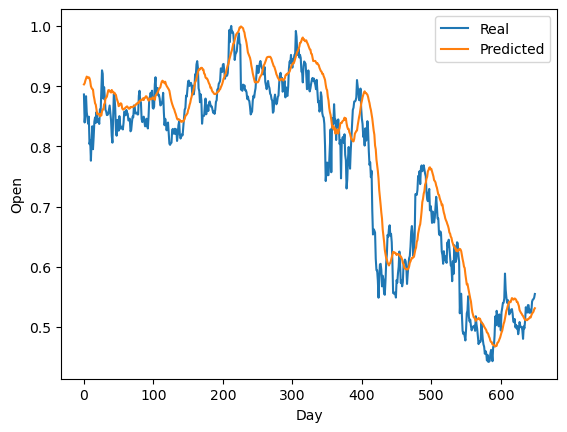

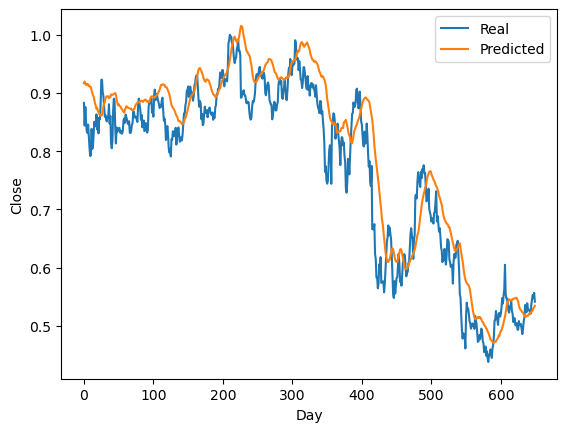

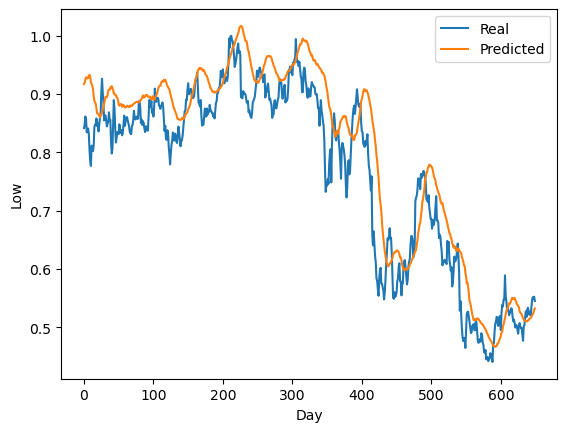

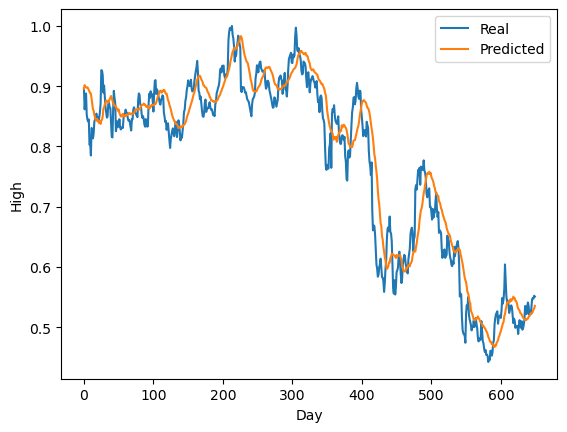

In [537]:
plt.plot(y_test[:1000, 0], label = 'Real')
plt.plot(y_predicted[:1000, 0], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Open')
plt.show()

plt.plot(y_test[:1000, 1], label = 'Real')
plt.plot(y_predicted[:1000, 1], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

plt.plot(y_test[:1000, 2], label = 'Real')
plt.plot(y_predicted[:1000, 2], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Low')
plt.show()

plt.plot(y_test[:1000, 3], label = 'Real')
plt.plot(y_predicted[:1000, 3], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('High')
plt.show()

In [ ]:
with torch.no_grad():
    inputs = X_train.to(device)
    inputs = inputs.view(inputs.size(0), 1, -1)
    print(inputs.shape)
    y_predicted = model.forward(inputs).to('cpu').numpy()
    
plt.plot(y_train[:1000], label = 'Real')
plt.plot(y_predicted[:1000], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

In [ ]:
with torch.no_grad():
    inputs = X_test.to(device)
    inputs = inputs.view(inputs.size(0), 1, -1)
    print(inputs.shape)
    y_predicted = model.forward(inputs).to('cpu').numpy()
    
plt.plot(y_train[:1000], label = 'Real')
plt.plot(y_predicted[:1000], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

**Resources**
- Tutorial em vídeo: https://www.youtube.com/watch?v=q_HS4s1L8UI